In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%store -r

/home/maarten/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


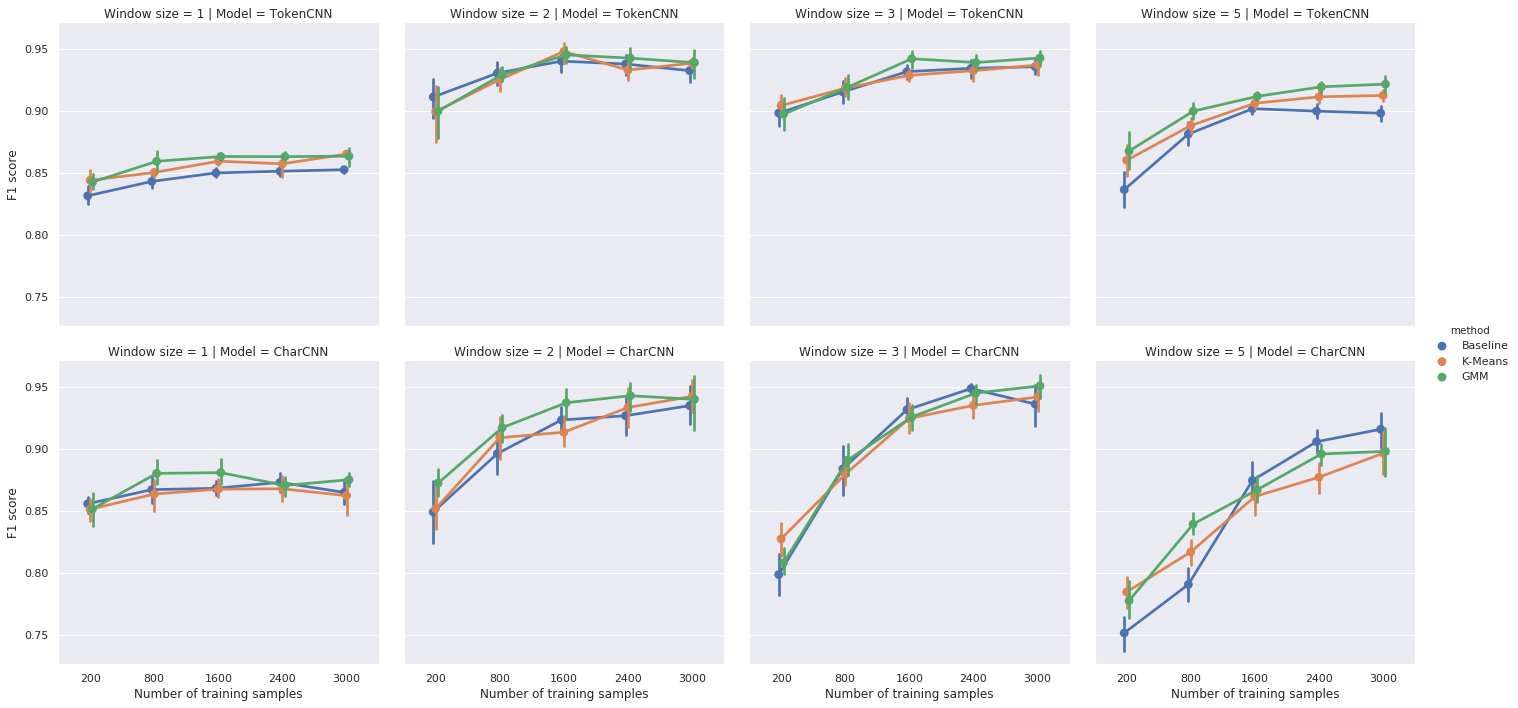

In [14]:
sns.set()

df = pd.concat([df_window0, df_window1, df_window2, df_window4])
df.window += 1

# fix the indices, which are fucked up by concat
df = df.reset_index(drop=True)

g = sns.catplot(
    x="size", y="score", data=df, kind="point", hue="method", row="model", col="window",
    dodge=True,
)
g.set_axis_labels("Number of training samples", "F1 score")
g.set_titles(col_template="Model = {row_name}", row_template="Window size = {col_name}")

plt.savefig("all_results.pdf")

In [9]:
from scipy.stats import ttest_rel

def p(s):
    i = s.keys()[0]
    size = df.iloc[i]["size"]
    method = df.iloc[i]["method"]
    model = df.iloc[i]["model"]
    window = df.iloc[i]["window"]

    baseline_scores = df[(df["size"] == size) & (df["model"] == model) & (df["method"] == "Baseline") & (df["window"] == window)].score
    scores = s.tolist()
    return ttest_rel(baseline_scores, scores)[1]

In [10]:
print("Full data:")
bl = df[df.method == "Baseline"]["score"]
gmm = df[df.method == "GMM"]["score"]
km = df[df.method == "K-Means"]["score"]
print(f"Baseline mean: {bl.mean()}")
print("GMM:")
print(f"mean: {gmm.mean()}")
print(f"p = {ttest_rel(bl, gmm)[1]}")
print()
print("K-Means:")
print(f"mean: {km.mean()}")
print(f"p = {ttest_rel(bl, km)[1]}")
print(f"p(K-Means == GMM) = {ttest_rel(km, gmm)[1]}")

print("\nIgnoring window size 0:")
bl = df[(df.method == "Baseline") & (df.window != 1)]["score"]
gmm = df[(df.method == "GMM") & (df.window != 1)]["score"]
km = df[(df.method == "K-Means") & (df.window != 1)]["score"]
print(f"Baseline mean: {bl.mean()}")
print("GMM:")
print(f"mean: {gmm.mean()}")
print(f"p = {ttest_rel(bl, gmm)[1]}")
print()
print("K-Means:")
print(f"mean: {km.mean()}")
print(f"p = {ttest_rel(bl, km)[1]}")
print(f"p(K-Means == GMM) = {ttest_rel(km, gmm)[1]}")

Full data:
Baseline mean: 0.8876449883085448
GMM:
mean: 0.8967570825612186
p = 1.7203499380417514e-12

K-Means:
mean: 0.890574898195001
p = 0.025607420245939313
p(K-Means == GMM) = 3.3741352164763556e-08

Ignoring window size 0:
Baseline mean: 0.8983062629427201
GMM:
mean: 0.9073689230609648
p = 1.5533457177664798e-08

K-Means:
mean: 0.901169319200861
p = 0.07532386802445104
p(K-Means == GMM) = 3.7050862755679167e-06


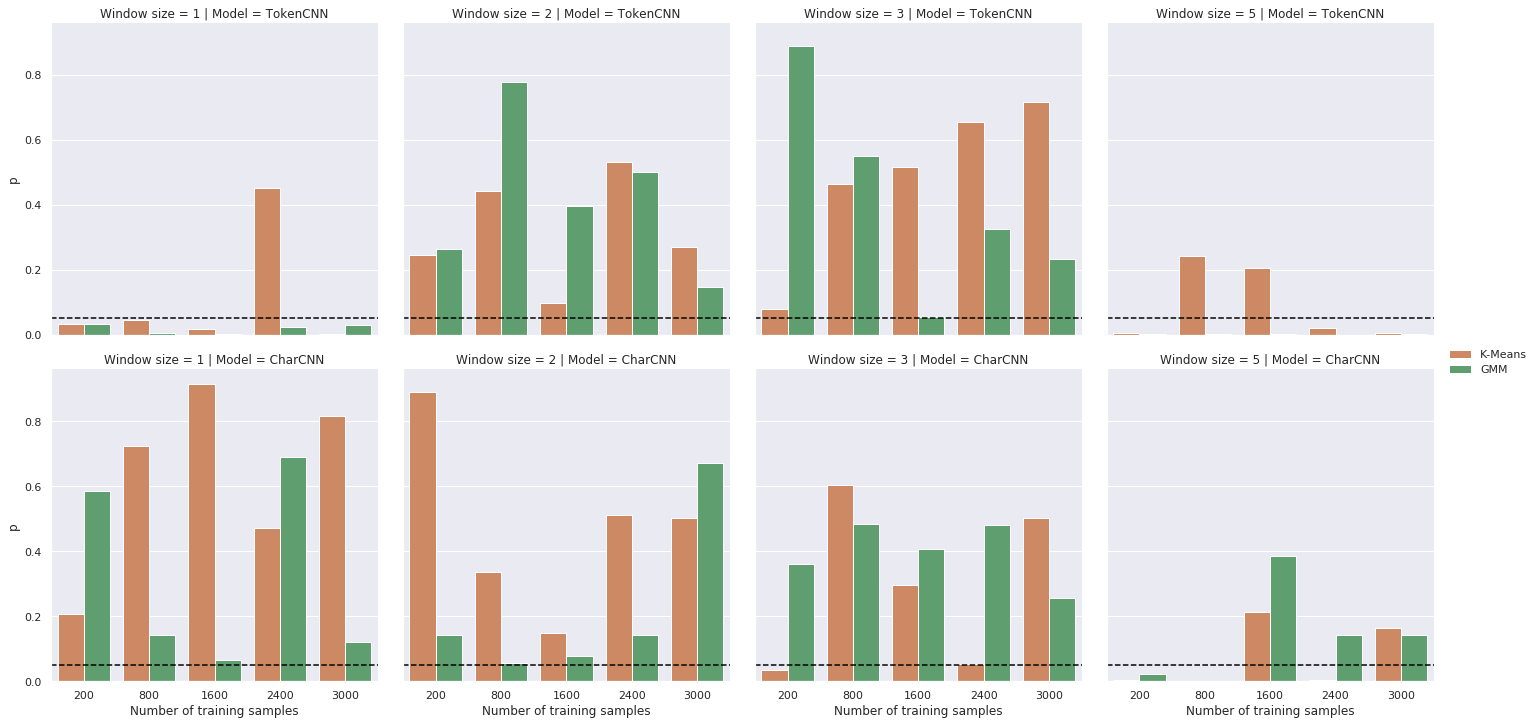

In [16]:
p_df = df.groupby(["window", "size", "model", "method"], sort=False).aggregate(p)
p_df = p_df.reset_index()

p_df = p_df[p_df["method"] != "Baseline"]
#g = sns.FacetGrid(p_df, col="model", row="window")
#g = g.map_dataframe(sns.barplot, x="size", y="score", hue="method")
g = sns.catplot(
    x="size", y="score", data=p_df, kind="bar", hue="method", row="model", col="window", legend=False,
    palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]),
)
g.map(plt.axhline, y=0.05, ls="--", c="black")
g.set_axis_labels("Number of training samples", "p")
g.set_titles(col_template="Model = {row_name}", row_template="Window size = {col_name}")
g.add_legend()
plt.savefig("all_results_p.pdf")